### Data Importing

In [8]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
#Colors for the Visualization
colors = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
#Reading the data
data = pd.read_csv('PJME_hourly.csv')
data.Datetime = pd.to_datetime(data.Datetime)

In [3]:
data.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


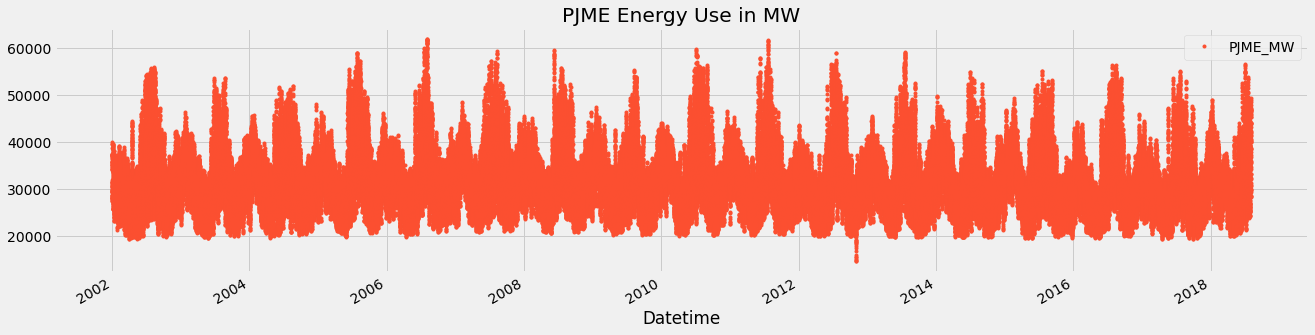

In [41]:
#Plotting the data using matplotlib library
data.plot(x='Datetime', y='PJME_MW', style='.', figsize=(20, 5), color=colors[1], title='PJME Energy Use in MW')
plt.show()

### Creating new Features into Dataset

In [6]:
def create_features(data):
    """
    Creating time series features based on time series index.
    """
    data = data.copy()
    data['hour'] = data.Datetime.dt.hour
    data['dayofweek'] = data.Datetime.dt.dayofweek
    data['quarter'] = data.Datetime.dt.quarter
    data['month'] = data.Datetime.dt.month
    data['year'] = data.Datetime.dt.year
    data['dayofyear'] = data.Datetime.dt.dayofyear
    data['dayofmonth'] = data.Datetime.dt.day
    data['weekofyear'] = data.Datetime.dt.isocalendar().week
    data['date_offset'] = (data.Datetime.dt.month*100 + data.Datetime.dt.day - 320)%1300
    data['season'] = pd.cut(data['date_offset'], [0, 300, 602, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])
    return data

data = create_features(data)

In [9]:
data.head()

,Datetime,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season
0,2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,911,Winter
1,2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,911,Winter
2,2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1,911,Winter
3,2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1,911,Winter
4,2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1,911,Winter


In [10]:
# We cannot process the categorical columns while using Machine Learning. We need to convert the categorical variable into numeric
y = pd.get_dummies(data.season, prefix='season')
y.head()

,season_Spring,season_Summer,season_Fall,season_Winter
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [11]:
# Joined the dummies with the orginal data
data= data.join(y) 


In [42]:
data.head()

,Datetime,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season,season_Spring,season_Summer,season_Fall,season_Winter
0,2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,911,Winter,0,0,0,1
1,2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,911,Winter,0,0,0,1
2,2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1,911,Winter,0,0,0,1
3,2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1,911,Winter,0,0,0,1
4,2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1,911,Winter,0,0,0,1


### Train and Test Data

In [43]:
import sklearn
from sklearn.model_selection import train_test_split

# Selecting the Variables for the Target and Feature Variable
X = data[['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'season_Spring', 'season_Summer', 'season_Fall', 'season_Winter', 'Datetime']]
y = data['PJME_MW']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

In [44]:
X_test1= X_test

In [45]:
# Deleting the Date and time variable in the Features Dataset
X_train= X_train.drop(columns= ['Datetime'])
X_test= X_test.drop(columns= ['Datetime'])

In [46]:
X_train.head()

,dayofyear,hour,dayofweek,quarter,month,year,season_Spring,season_Summer,season_Fall,season_Winter
0,365,1,1,4,12,2002,0,0,0,1
1,365,2,1,4,12,2002,0,0,0,1
2,365,3,1,4,12,2002,0,0,0,1
3,365,4,1,4,12,2002,0,0,0,1
4,365,5,1,4,12,2002,0,0,0,1


### XGBoost Machine Learning Model

In [47]:
# Training the model with XGBoost
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[19:33:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32730.62284	validation_1-rmse:31717.16777
[100]	validation_0-rmse:12567.22010	validation_1-rmse:11644.97588
[200]	validation_0-rmse:5801.28255	validation_1-rmse:5279.10294
[300]	validation_0-rmse:3896.16691	validation_1-rmse:3954.07466
[400]	validation_0-rmse:3446.53690	validation_1-rmse:3849.76715
[500]	validation_0-rmse:3296.86762	validation_1-rmse:3824.71899
[600]	validation_0-rmse:3221.23754	validation_1-rmse:3808.74173
[700]	validation_0-rmse:3166.72509	validation_1-rmse:3799.86546
[735]	validation_0-rmse:3152.59637	validation_1-rmse:3809.79198


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

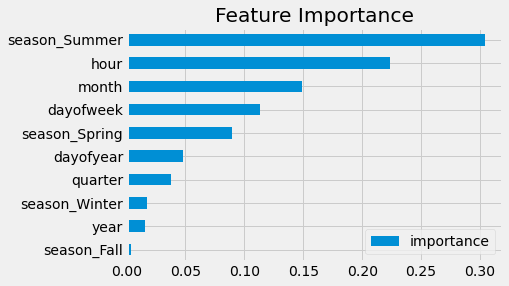

In [48]:
# Plotting the Important Features contributed in the machine learning
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [49]:
X_test.head()

,dayofyear,hour,dayofweek,quarter,month,year,season_Spring,season_Summer,season_Fall,season_Winter
97395,324,3,2,4,11,2013,0,0,1,0
97396,324,4,2,4,11,2013,0,0,1,0
97397,324,5,2,4,11,2013,0,0,1,0
97398,324,6,2,4,11,2013,0,0,1,0
97399,324,7,2,4,11,2013,0,0,1,0


In [50]:
# Predicting the variable Using X_test dataset
test = reg.predict(X_test)
test = pd.DataFrame(test, columns =['prediction'])
test.shape

(47971, 1)

In [51]:
test.head()

,prediction
0,24348.289062
1,24348.289062
2,24348.289062
3,25574.398438
4,28605.949219


In [52]:
y_test.head()

97395    26192.0
97396    26402.0
97397    27338.0
97398    29825.0
97399    33739.0
Name: PJME_MW, dtype: float64

### Calculating the RMSE score for XGBoost

In [29]:
RMSE = np.sqrt(mean_squared_error(y_test, test['prediction']))
print(f'RMSE Score of Test Data: {RMSE:0.2f}')

RMSE Score of Test Data: 3792.49


### Plotting the XGboost Machine learning predictions with the original data

In [53]:
X_test1.head()

,dayofyear,hour,dayofweek,quarter,month,year,season_Spring,season_Summer,season_Fall,season_Winter,Datetime
97395,324,3,2,4,11,2013,0,0,1,0,2013-11-20 03:00:00
97396,324,4,2,4,11,2013,0,0,1,0,2013-11-20 04:00:00
97397,324,5,2,4,11,2013,0,0,1,0,2013-11-20 05:00:00
97398,324,6,2,4,11,2013,0,0,1,0,2013-11-20 06:00:00
97399,324,7,2,4,11,2013,0,0,1,0,2013-11-20 07:00:00


In [54]:
#Index is making difficult to join or plot the data. I have done some preprocessing before plotting the graph
index= X_test1.index
index= pd.DataFrame(index, columns =['index'])

In [55]:
index.head()

,index
0,97395
1,97396
2,97397
3,97398
4,97399


In [56]:
# TO merge X_test and test prediction we need to reset the index and join the both the datasets
X_test1 = X_test1.reset_index(drop=True)
test= test.reset_index(drop= True)

In [57]:
test["Datetime"]= X_test1["Datetime"]

In [58]:
test.head()

,prediction,Datetime
0,24348.289062,2013-11-20 03:00:00
1,24348.289062,2013-11-20 04:00:00
2,24348.289062,2013-11-20 05:00:00
3,25574.398438,2013-11-20 06:00:00
4,28605.949219,2013-11-20 07:00:00


In [59]:
#Merged the datasets with indexes
test1= X_test1.merge(test, how= 'left', left_index=True, right_index=True)
test1.shape

(47971, 13)

In [60]:
test1.head()

,dayofyear,hour,dayofweek,quarter,month,year,season_Spring,season_Summer,season_Fall,season_Winter,Datetime_x,prediction,Datetime_y
0,324,3,2,4,11,2013,0,0,1,0,2013-11-20 03:00:00,24348.289062,2013-11-20 03:00:00
1,324,4,2,4,11,2013,0,0,1,0,2013-11-20 04:00:00,24348.289062,2013-11-20 04:00:00
2,324,5,2,4,11,2013,0,0,1,0,2013-11-20 05:00:00,24348.289062,2013-11-20 05:00:00
3,324,6,2,4,11,2013,0,0,1,0,2013-11-20 06:00:00,25574.398438,2013-11-20 06:00:00
4,324,7,2,4,11,2013,0,0,1,0,2013-11-20 07:00:00,28605.949219,2013-11-20 07:00:00


In [61]:
# While merging the dataset, two other columns generated 'Datetime_x' for the first dataset and 'Datetime_y' for the second dataset. Removing the both will make the dataset look good
test1 = test1.rename(columns={'Datetime_x': 'Datetime'})
test1= test1.drop(columns= 'Datetime_y')
test1.head()

,dayofyear,hour,dayofweek,quarter,month,year,season_Spring,season_Summer,season_Fall,season_Winter,Datetime,prediction
0,324,3,2,4,11,2013,0,0,1,0,2013-11-20 03:00:00,24348.289062
1,324,4,2,4,11,2013,0,0,1,0,2013-11-20 04:00:00,24348.289062
2,324,5,2,4,11,2013,0,0,1,0,2013-11-20 05:00:00,24348.289062
3,324,6,2,4,11,2013,0,0,1,0,2013-11-20 06:00:00,25574.398438
4,324,7,2,4,11,2013,0,0,1,0,2013-11-20 07:00:00,28605.949219


In [62]:
# 'index' is a dataframe define above. We have first reset the index and then again assigning the same index to test1 so that there would be a successful join the datasets.
# index play a major role in time series data
test1= test1.set_index(index['index'])

In [63]:
test1.head()

,dayofyear,hour,dayofweek,quarter,month,year,season_Spring,season_Summer,season_Fall,season_Winter,Datetime,prediction
index,,,,,,,,,,,,
97395,324,3,2,4,11,2013,0,0,1,0,2013-11-20 03:00:00,24348.289062
97396,324,4,2,4,11,2013,0,0,1,0,2013-11-20 04:00:00,24348.289062
97397,324,5,2,4,11,2013,0,0,1,0,2013-11-20 05:00:00,24348.289062
97398,324,6,2,4,11,2013,0,0,1,0,2013-11-20 06:00:00,25574.398438
97399,324,7,2,4,11,2013,0,0,1,0,2013-11-20 07:00:00,28605.949219


In [64]:
data.head()

,Datetime,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,date_offset,season,season_Spring,season_Summer,season_Fall,season_Winter
0,2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,911,Winter,0,0,0,1
1,2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,911,Winter,0,0,0,1
2,2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1,911,Winter,0,0,0,1
3,2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1,911,Winter,0,0,0,1
4,2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1,911,Winter,0,0,0,1


In [65]:
# Now we can merge the X_test1 dataset with the orginal dataset to a new dataframe so that we can oberve the plot between the orginal and the predicting time series dataset
data1 = data.merge(test1,how= 'left', left_index=True, right_index=True)
data1.head()

,Datetime_x,PJME_MW,hour_x,dayofweek_x,quarter_x,month_x,year_x,dayofyear_x,dayofmonth,weekofyear,...,dayofweek_y,quarter_y,month_y,year_y,season_Spring_y,season_Summer_y,season_Fall_y,season_Winter_y,Datetime_y,prediction
0,2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1,2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
2,2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3,2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
4,2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN


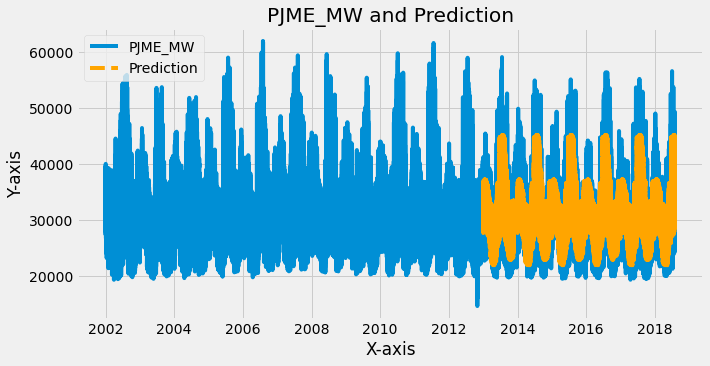

In [76]:
# Plotted two graphs in one plot. One is the original dataset and the other in the predicted dataset

x= data['Datetime']
plt.figure(figsize=(10, 5))
plt.plot(x, data['PJME_MW'], label='PJME_MW')
plt.plot(x, data1['prediction'], label='Prediction', linestyle='dashed', color='orange')

# Customize the plot
plt.title('PJME_MW and Prediction')
plt.xlabel('X-axis')  # Replace 'X-axis' with the appropriate label
plt.ylabel('Y-axis')  # Replace 'Y-axis' with the appropriate label
plt.legend()

# Display the plot
plt.show()